# Detection of Fake / Real Profiles

## Support Vector Machine and Random Forest

#### Importing packages needed

In [1]:
import sys
import csv
from sklearn import svm
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import gender_guesser.detector as gender

from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc ,roc_auc_score

from sklearn.ensemble import RandomForestClassifier

#### Reading the dataset and assigning variables

In [2]:
def read_user_datasets():
    # Reads users profile from csv files
    real_users = pd.read_csv("dataset/data/users.csv")
    fake_users = pd.read_csv("dataset/data/fusers.csv")
    
    x = pd.concat([real_users,fake_users])    
    y = len(fake_users)*[1] + len(real_users)*[0]
    #print(y)
    
    return x,y

#### Predicting gender of user

In [3]:
def predict_user_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    code = sex_code_dict[sex]
    
    return code

#### Function for extracting features used for the prediction

In [4]:
def extract_user_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    
    lang_dict = { name : i for i, name in lang_list }             
    
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_user_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    
    return x

#### Function for plotting the curve

In [5]:
def plot_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

###### plot_roc_curve(): plots ROC curve

In [14]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc, color='c')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--', color='magenta')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Function for creating the confusion matrix

In [6]:
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Spectral):
    target_names=['Fake','Real']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Function that Trains and predicts dataset with a SVM classifier

In [7]:
def train(X_train,y_train,X_test, nSplits, CV):
    # Scaling features
    xx_train = preprocessing.scale(X_train)
    xx_test = preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    
    cvk = StratifiedKFold(n_splits= nSplits)
    
    classifier = svm.SVC()
    
    clf = GridSearchCV(classifier, param_grid=param, cv=cvk, return_train_score=True)
    clf.fit(xx_train,y_train)
    
    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(xx_train, y_train)
    
    # Estimate score
    scores = cross_validate(clf.best_estimator_, xx_train,y_train, cv=CV)
    
    for k in [*scores]:
        print(k + ": ", scores[k])
    
    title = 'Learning Curves (SVM, rbf kernel, gamma={})'.format(clf.best_estimator_.gamma)
    
    plot_curve(clf.best_estimator_, title, xx_train, y_train, cv=CV)
    plt.show()
    
    # Predict class
    y_pred = clf.best_estimator_.predict(xx_test)
    
    return y_test,y_pred

In [8]:
x,y = read_user_datasets()
print("dataset read complete.....")

dataset read complete.....


In [9]:
x = extract_user_features(x)
print(x.columns)

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')


In [10]:
# splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)
#print(X_train,X_test,y_train,y_test)

The best classifier is:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
fit_time:  [0.06781912 0.07481956 0.06978416 0.07273889 0.07079554 0.06880355
 0.06987786]
score_time:  [0.00797725 0.00692558 0.00694966 0.00702572 0.00699306 0.00695252
 0.00791168]
test_score:  [0.91640867 0.94117647 0.92236025 0.9378882  0.9378882  0.96261682
 0.94392523]


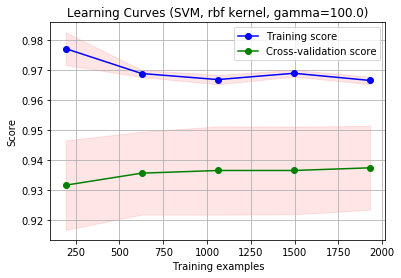

In [11]:
y_test,y_pred = train(X_train,y_train,X_test,5, 7)

Confusion matrix, without normalization
[[243  53]
 [  3 265]]


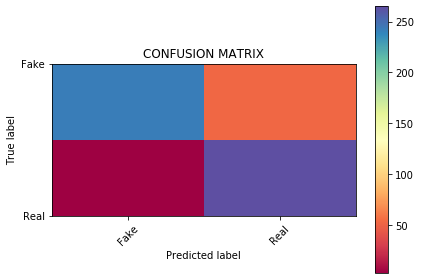

In [14]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(confusionMatrix)
plot_confusion_matrix(confusionMatrix)

In [16]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.99      0.82      0.90       296
     Genuine       0.83      0.99      0.90       268

    accuracy                           0.90       564
   macro avg       0.91      0.90      0.90       564
weighted avg       0.91      0.90      0.90       564



In [17]:
s=roc_auc_score(y_test, y_pred)
print("roc_auc_score : ",s)

roc_auc_score :  0.9048759580475999


False Positive rate:  [0.         0.17905405 1.        ]
True Positive rate:  [0.         0.98880597 1.        ]


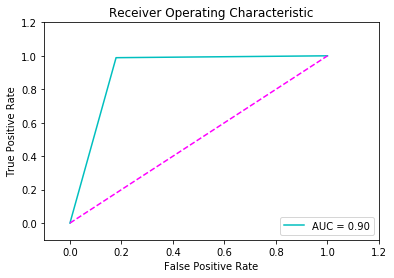

In [18]:
 plot_roc_curve(y_test, y_pred)

####  Random forest

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)
XX_train,XX_test,yy_train,yy_test = train_test_split(x, y, test_size=0.20, random_state=44)
rf_classifier.fit(XX_train, yy_train)
train_predictions = rf_classifier.predict(XX_train)
prediction = rf_classifier.predict(XX_test)

False Positive rate:  [0.         0.10135135 1.        ]
True Positive rate:  [0.         0.97014925 1.        ]


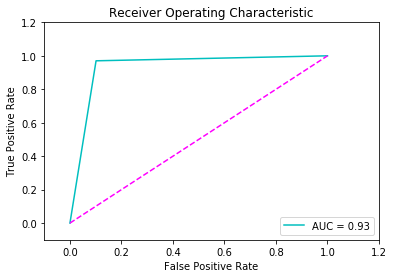

Train Accuracy is : 93.74445430346051
Test Accuracy is : 93.26241134751773


In [15]:
err_training = mean_absolute_error(train_predictions, yy_train)
err_test = mean_absolute_error(prediction, yy_test)

plot_roc_curve(yy_test, prediction)

print("Train Accuracy is : {}".format(100 - (100*err_training)))
print("Test Accuracy is : {}".format(100 - (100*err_test)))

Confusion matrix, without normalization
[[266  30]
 [  8 260]]


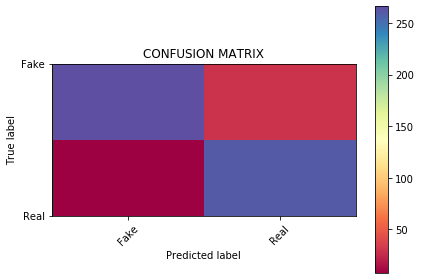

In [16]:
confusionMatrixx = confusion_matrix(yy_test, prediction)
print('Confusion matrix, without normalization')
print(confusionMatrixx)
plot_confusion_matrix(confusionMatrixx)